# 导入项目所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import chinese_calendar


# 读取sales这个DataFrame

In [2]:
sales = pd.read_csv('inHtl_cii_compfz.csv')

### 检查DataFrame

In [3]:
sales

,starttime,hotelid,notcancelcii
0,2015-1-1,352972,217
1,2015-1-1,376834,307
2,2015-1-1,382765,77
3,2015-1-1,400229,55
4,2015-1-1,404224,139
...,...,...,...
195120,2015-12-31,3240256,3
195121,2015-12-31,3574765,3
195122,2015-12-31,3723045,13
195123,2015-12-31,3785874,41


## 将strattime设为日期型

In [4]:
sales['starttime']=pd.to_datetime(sales['starttime'])#将strattime设为日期型

## 2构造月份特征（一年的第几个月）3星期特征（一周的第几天）

In [5]:
sales['month']=sales['starttime'].dt.month

In [6]:
sales['week']=sales['starttime'].dt.isocalendar().week

## 4通过starttime构造weekday特征（一周的第几天）

In [7]:
sales['weekday']=sales['starttime'].dt.weekday
sales['weekday']=sales['weekday']+1

In [8]:
import datetime

## 5调用函数添加holiday特征，6构造调休日特征

In [9]:
from chinese_calendar import is_holiday, is_workday
# 使用chinesecalendar来判断每个日期是否为工作日
def construct_workday_feature(sales):
    sales['workday'] = sales['starttime'].apply(lambda x: is_workday(x))
    return sales
# 调用函数添加workday特征
sales = construct_workday_feature(sales)
# 使用chinesecalendar来判断每个日期是否为调休日
def construct_holiday_feature(sales):
    sales['holiday'] = sales['starttime'].apply(lambda x: is_holiday(x))
    return sales
# 调用函数添加holiday特征
sales = construct_holiday_feature(sales)
# 打印结果
print(sales)


        starttime  hotelid  notcancelcii  month  week  weekday  workday  \
0      2015-01-01   352972           217      1     1        4    False   
1      2015-01-01   376834           307      1     1        4    False   
2      2015-01-01   382765            77      1     1        4    False   
3      2015-01-01   400229            55      1     1        4    False   
4      2015-01-01   404224           139      1     1        4    False   
...           ...      ...           ...    ...   ...      ...      ...   
195120 2015-12-31  3240256             3     12    53        4     True   
195121 2015-12-31  3574765             3     12    53        4     True   
195122 2015-12-31  3723045            13     12    53        4     True   
195123 2015-12-31  3785874            41     12    53        4     True   
195124 2015-12-31  4112984             3     12    53        4     True   

        holiday  
0          True  
1          True  
2          True  
3          True  
4        

## 7对各个酒店分别构造间夜量均值特征、方差特征、最大、最小值特征（groupby）


### 计算每个'hotelid'的平均'notcancelcii'值，并将结果添加到新列'sales_mean'中

In [10]:
sales['sales_mean']=sales.groupby("hotelid")["notcancelcii"].transform("mean")

### 同理计算方差，最大最小值

In [11]:
sales['sales_std']=sales.groupby("hotelid")["notcancelcii"].transform("std")
sales['sales_max']=sales.groupby("hotelid")["notcancelcii"].transform("max")
sales['sales_min']=sales.groupby("hotelid")["notcancelcii"].transform("min")

## 8新的列sales_lag1_mean，计算每个hotelid的间夜量前一个月的平均值

In [12]:
sales['sales_lag_mean'] = sales.groupby('hotelid')['notcancelcii'].transform(lambda x:x.shift(30).rolling(30).mean())

In [13]:
month_mean = sales.groupby(['hotelid','month'])['notcancelcii'].mean()

In [14]:
month_mean

hotelid  month
119308   1         5.142857
351642   1        41.193548
         2        70.214286
         3        41.451613
         4        56.933333
                    ...    
4112984  12        3.000000
4115510  12        9.000000
4116646  12        3.000000
4124088  12        3.000000
4125367  12        5.000000
Name: notcancelcii, Length: 14625, dtype: float64

In [15]:
sales = pd.merge(sales,month_mean.groupby('hotelid').shift(1),on = ['hotelid','month'],how = 'left')

# 9读入价格数据

In [16]:
price = pd.read_csv('hotelminprice_comp.csv')

In [17]:
price

,hotelid,efdate,minprice
0,21987,2015/1/1,198.0
1,21987,2015/1/2,198.0
2,21987,2015/1/3,198.0
3,21987,2015/1/4,198.0
4,21987,2015/1/5,198.0
...,...,...,...
934803,4587536,2015/7/27,100000.0
934804,4587536,2015/7/28,100000.0
934805,4587536,2015/7/29,100000.0
934806,4587536,2015/7/30,100000.0


### 把efdate设为日期型，方便合并

In [18]:
price['efdate']=pd.to_datetime(price['efdate'])

## 10与间夜量数据合并，形成间夜量表中的价格特征

### 以旅馆ID和时间作关键词合并，并让sales在左边

In [19]:
sales=pd.merge(sales,price,left_on=["hotelid","starttime"],right_on=["hotelid","efdate"],how="left")

### 为'minprice'列创建箱型图

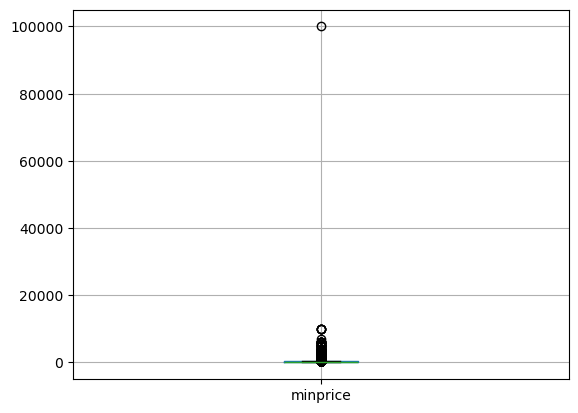

In [20]:
sales.boxplot(column=["minprice"])
plt.show()

## 11对价格特征诊断异常值，并将异常值设为缺失值

### 识别每个hotelid的minprice列的异常值，异常值定义为大于该组99%数的值。

In [21]:
price_outlier =sales['minprice']>sales.groupby("hotelid")["minprice"].transform("quantile",0.99)


### 将识别出异常值的数据替换为None

In [22]:
sales.loc[price_outlier,"minprice"] = None

## 12进行填充处理

In [23]:
sales["minprice"] =sales.groupby("hotelid")["minprice"].ffill().bfill() 

### 计算缺失值的数量,检查是否还有缺失值

In [24]:
sales["minprice"].isna().sum()

0

# 13读取位置数据


In [25]:
zone=pd.read_csv("hotelstaticinfo_comp.csv")
zone

,hotelid,zone,mgrgroup,gdlat,gdlon,isstraightconnect,star
0,1818,656.0,0.0,31.166143,120.338348,F,3
1,1835,NaN,NaN,NaN,NaN,F,2
2,1866,-1.0,0.0,31.332085,120.578812,F,3
3,1875,211.0,0.0,31.315073,120.620117,F,3
4,1945,NaN,NaN,NaN,NaN,F,2
...,...,...,...,...,...,...,...
8676,4910146,208.0,0.0,NaN,NaN,T,2
8677,4910146,208.0,0.0,31.326521,120.613586,F,2
8678,4910146,208.0,0.0,NaN,NaN,F,2
8679,5052754,-1.0,0.0,NaN,NaN,T,3


## 14与间夜量表合并,形成间夜量表中的zone，star，isstraightconnect特征

In [26]:
sales=pd.merge(sales,zone,left_on=["hotelid"],right_on=["hotelid"],how="left")

In [27]:
sales

,starttime,hotelid,notcancelcii_x,month,week,weekday,workday,holiday,sales_mean,sales_std,...,sales_lag_mean,notcancelcii_y,efdate,minprice,zone,mgrgroup,gdlat,gdlon,isstraightconnect,star
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,31.290419,120.617050,F,5
1,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,NaN,NaN,F,5
2,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,NaN,NaN,T,5
3,2015-01-01,376834,307,1,1,4,False,True,62.280220,65.137604,...,NaN,NaN,2015-01-01,826.0,1060.0,32.0,31.322004,120.682304,F,5
4,2015-01-01,376834,307,1,1,4,False,True,62.280220,65.137604,...,NaN,NaN,2015-01-01,826.0,1060.0,32.0,NaN,NaN,T,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671518,2015-12-31,3785874,41,12,53,4,True,False,13.769231,12.504358,...,NaN,NaN,2015-12-31,128.0,208.0,162.0,NaN,NaN,F,2
671519,2015-12-31,3785874,41,12,53,4,True,False,13.769231,12.504358,...,NaN,NaN,2015-12-31,128.0,208.0,162.0,NaN,NaN,T,2
671520,2015-12-31,4112984,3,12,53,4,True,False,3.000000,0.000000,...,NaN,NaN,2015-12-31,76.0,210.0,0.0,31.287289,120.551231,F,2
671521,2015-12-31,4112984,3,12,53,4,True,False,3.000000,0.000000,...,NaN,NaN,2015-12-31,76.0,210.0,0.0,NaN,NaN,F,2


# 可视化分析

## 15酒店平均间夜量的时间序列

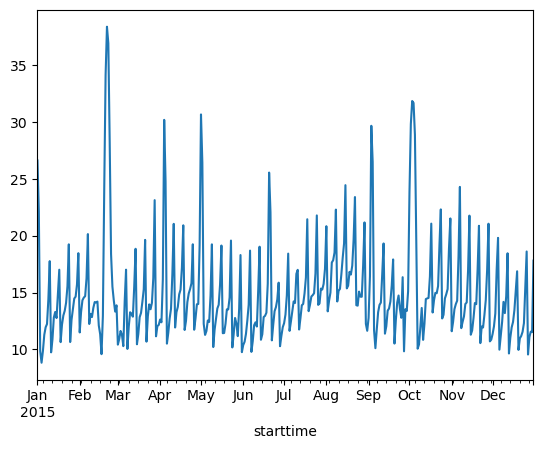

In [28]:
#对'starttime'分组并计算'notcancelcii'的平均值
sales_mean = sales.groupby("starttime")['notcancelcii_x'].mean()
# 绘制平均值的线形图
sales_mean.plot()
plt.show()

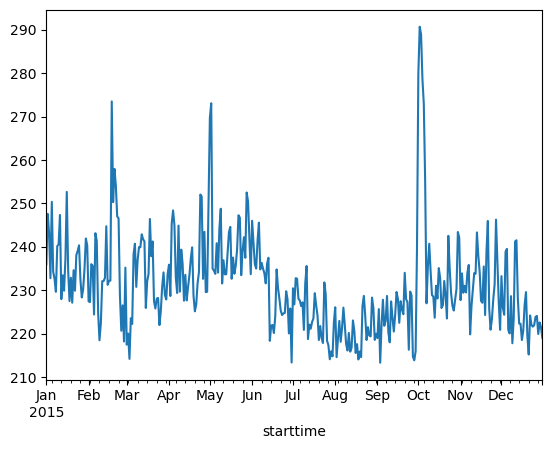

In [29]:
##对'starttime'分组并计算'minprice'的平均值
price_mean = sales.groupby("starttime")['minprice'].mean()
price_mean.plot()
plt.show()
#由图可以看出十月价格最高，猜想是十一国庆期间旅馆生意最好，八月间价格最低

## 16酒店平均间夜量与平均价格的关系

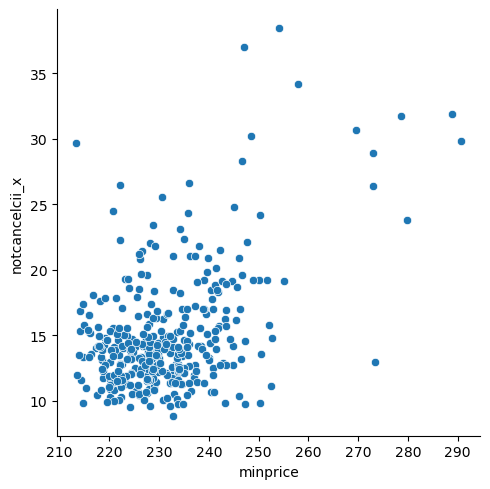

In [30]:
import seaborn as sn
sn.relplot(x=price_mean,y=sales_mean)#绘制散点图
plt.show()
#在价格为220~240时间夜量比较集中，而价格超过250后间夜量较高，推测在订单较多时，价格可以适当提升，从而获得更高利润

### 将索引作为数据的一部分进行分析和可视化

In [31]:
sales_mean = sales_mean.reset_index()

In [32]:
price_mean

starttime
2015-01-01    236.006477
2015-01-02    247.597898
2015-01-03    243.217805
2015-01-04    232.811460
2015-01-05    250.366487
                 ...    
2015-12-27    224.121528
2015-12-28    219.955862
2015-12-29    222.618361
2015-12-30    221.529605
2015-12-31    219.032905
Name: minprice, Length: 365, dtype: float64

In [33]:
sales_mean

,starttime,notcancelcii_x
0,2015-01-01,26.631290
1,2015-01-02,22.133850
2,2015-01-03,9.831461
3,2015-01-04,8.828096
4,2015-01-05,9.867384
...,...,...
360,2015-12-27,9.551389
361,2015-12-28,11.082759
362,2015-12-29,11.562623
363,2015-12-30,11.522368


## 17酒店平均间夜量与weekday的关系

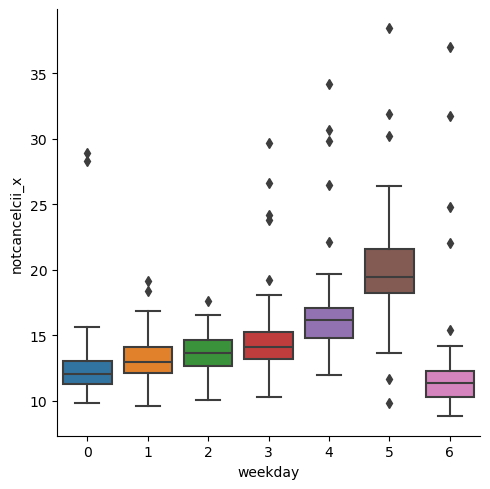

In [34]:
sales_mean['weekday'] = sales_mean['starttime'].dt.dayofweek
sn.catplot(data=sales_mean,x='weekday',y='notcancelcii_x',kind='box')
plt.show()
#箱形图0~6表示周一到周日。周五、周六，周日间夜量明显提升，表示非工作日在旅馆人数更多

## 18酒店平均间夜量与holiday的关系

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 20241 (\N{CJK UNIFIED IDEOGRAPH-4F11}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20241 (\N{CJK UNIFIED IDEOGRAPH-4F11}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserW

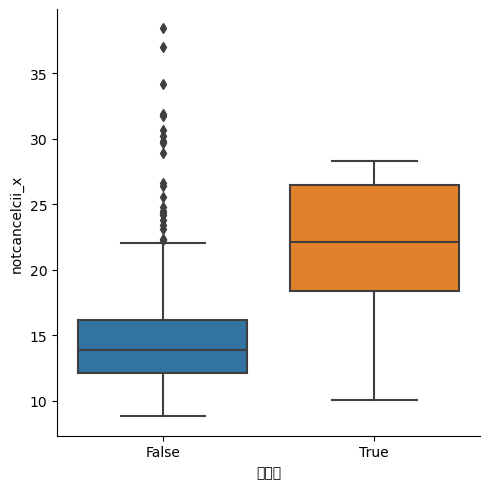

In [35]:
sales_mean['调休日'] = sales_mean['starttime'].apply(lambda x:chinese_calendar.is_in_lieu(x))
sn.catplot(data=sales_mean,x='调休日',y='notcancelcii_x',kind="box")
plt.show()
#是调休日的情况下，间夜量明显高于非调休

## 19酒店平均间夜量与月份的关系

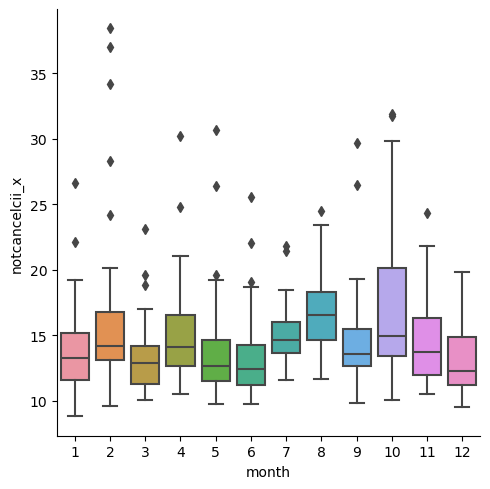

In [36]:
sales_mean['month'] = sales_mean['starttime'].dt.month
sn.catplot(data=sales_mean,x='month',y='notcancelcii_x',kind='box')
plt.show()
#创建月份和间夜量关系箱型图，大部分月份在15~20浮动，10月最高

## 20酒店平均间夜量与zone的关系

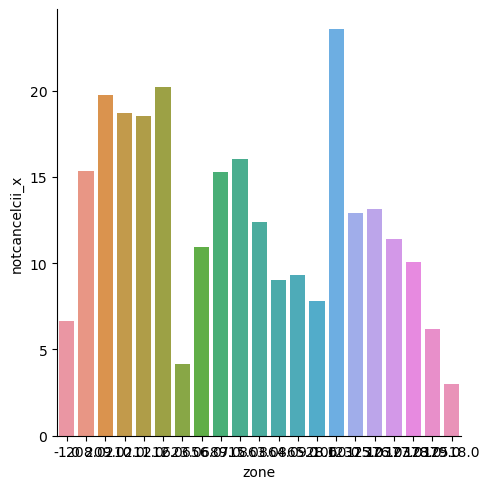

In [37]:
sales_zone = sales.groupby('zone')['notcancelcii_x'].mean().reset_index()
sn.catplot(data=sales_zone,x='zone',y='notcancelcii_x',kind="bar")
plt.show()
#平均间夜量与位置关系

## 21酒店平均间夜量与star的关系

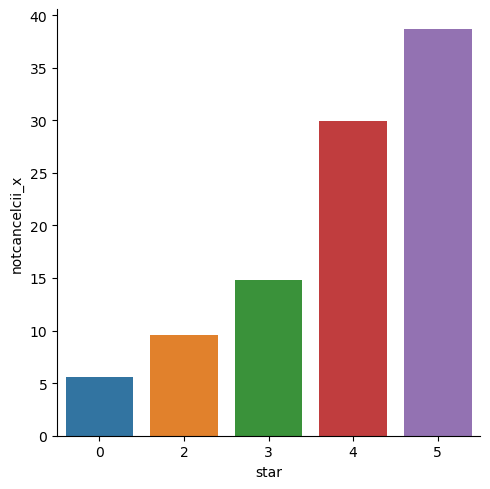

In [38]:
sales_star = sales.groupby('star')['notcancelcii_x'].mean().reset_index()
sn.catplot(data=sales_star,x='star',y='notcancelcii_x',kind="bar")
plt.show()
#平均间夜量与星级关系，四星五星级旅馆间夜量较高

## 22平均价格与与zone的关系

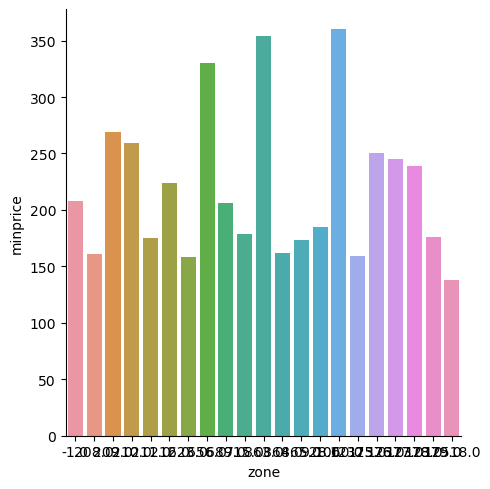

In [39]:
price_zone = sales.groupby('zone')['minprice'].mean().reset_index()
sn.catplot(data=price_zone,x='zone',y='minprice',kind="bar")
plt.show()
#平均价格与地址关系

## 23平均价格与与star的关系

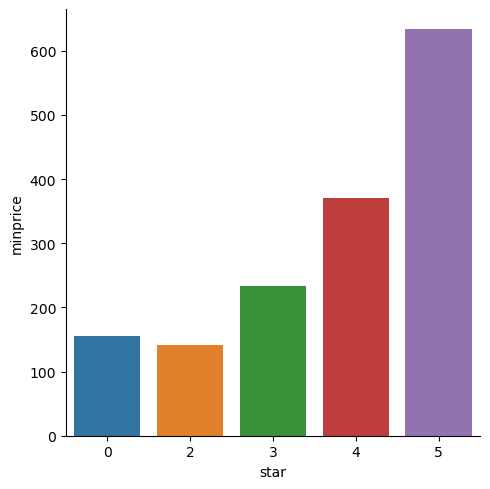

In [40]:
price_star = sales.groupby('star')['minprice'].mean().reset_index()
sn.catplot(data=price_star,x='star',y='minprice',kind="bar")
plt.show()
#平均价格与star关系，5星级旅馆价格远高于4星级旅馆价格

## 24根据时间顺序划分训练集，验证集，测试集（最后一个月）

In [41]:
train = sales['starttime']<pd.to_datetime('2015-11-01')
test = sales['starttime']>pd.to_datetime('2015-12-01')
val = sales['starttime']>pd.to_datetime('2015-11-01')

In [42]:
sales

,starttime,hotelid,notcancelcii_x,month,week,weekday,workday,holiday,sales_mean,sales_std,...,sales_lag_mean,notcancelcii_y,efdate,minprice,zone,mgrgroup,gdlat,gdlon,isstraightconnect,star
0,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,31.290419,120.617050,F,5
1,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,NaN,NaN,F,5
2,2015-01-01,352972,217,1,1,4,False,True,60.287671,64.110456,...,NaN,NaN,2015-01-01,511.0,212.0,0.0,NaN,NaN,T,5
3,2015-01-01,376834,307,1,1,4,False,True,62.280220,65.137604,...,NaN,NaN,2015-01-01,826.0,1060.0,32.0,31.322004,120.682304,F,5
4,2015-01-01,376834,307,1,1,4,False,True,62.280220,65.137604,...,NaN,NaN,2015-01-01,826.0,1060.0,32.0,NaN,NaN,T,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671518,2015-12-31,3785874,41,12,53,4,True,False,13.769231,12.504358,...,NaN,NaN,2015-12-31,128.0,208.0,162.0,NaN,NaN,F,2
671519,2015-12-31,3785874,41,12,53,4,True,False,13.769231,12.504358,...,NaN,NaN,2015-12-31,128.0,208.0,162.0,NaN,NaN,T,2
671520,2015-12-31,4112984,3,12,53,4,True,False,3.000000,0.000000,...,NaN,NaN,2015-12-31,76.0,210.0,0.0,31.287289,120.551231,F,2
671521,2015-12-31,4112984,3,12,53,4,True,False,3.000000,0.000000,...,NaN,NaN,2015-12-31,76.0,210.0,0.0,NaN,NaN,F,2


## 25以间夜量为目标向量，以构造的特征为特征矩阵

将要预测的值nitcancelcii记为label,预测的关键词特征month等记为feature

In [43]:
features = ['month','week','weekday','holiday','workday','sales_mean','sales_std','sales_max','sales_min','sales_lag_mean'
            ,'notcancelcii_y','minprice','zone','mgrgroup','star']
label = 'notcancelcii_x'

In [44]:
sales[features] = sales[features].astype(np.float32)

In [45]:
sales[features].isna().sum()

month                  0
week                   0
weekday                0
holiday                0
workday                0
sales_mean             0
sales_std            621
sales_max              0
sales_min              0
sales_lag_mean    211966
notcancelcii_y     51804
minprice               0
zone                   0
mgrgroup             395
star                   0
dtype: int64

## 27超参数调优

在sales数据框中找到’mgrgroup’列值为NaN（即缺失或未定义）的行，并将这些单元格的值赋为-1
找到’sales_std’列缺失的行，并将该列的值设置为0
在sales数据框中创建了一个名为’sales_lagl_mean2’的新列。这个新列使用’hotelid’列进行分组，对’sales_lagl_mean2’列应用了前向填充（ffill）和后向填充（bfill）方法
用该列非缺失值的平均值填充’sales_lagl_mean2’列中的NaN值，

In [46]:
sales.loc[sales['mgrgroup'].isna(),'mgrgroup']=-1
sales.loc[sales['sales_std'].isna(),'sales_std']=0
sales['notcancelcii_y'] = sales.groupby('hotelid')['notcancelcii_y'].ffill().bfill()
sales['notcancelcii_y'].fillna(sales['notcancelcii_y'].mean(),inplace = True)

In [47]:
sales['sales_lag_mean'] = sales.groupby('hotelid')['sales_lag_mean'].ffill().bfill()
sales['sales_lag_mean'].fillna(sales['sales_lag_mean'].mean(),inplace = True)

In [48]:
cat_features = ['zone','mgrgroup','star']
sales[cat_features] = sales[cat_features].fillna(-1).astype('int').astype('category')

In [49]:
sales['zone'].cat.categories

Index([   -1,   208,   209,   210,   211,   212,   623,   656,   689,   715,
         863,   864,   865,   928,  1060, 12375, 12376, 12377, 12378, 12379,
       12518],
      dtype='int32')

In [50]:
sales['zone'].cat.codes

0          5
1          5
2          5
3         14
4         14
          ..
671518     1
671519     1
671520     3
671521     3
671522     3
Length: 671523, dtype: int8

In [51]:
X = pd.get_dummies(sales[features],columns = ['zone','mgrgroup','star'])

## 26分别用决策树，随机森林，梯度提升树等模型用训练集进行模型训练，并用验证集进行

In [52]:
X_tr,y_tr = X.loc[train,],sales.loc[train,label]
X_ts,y_ts = X.loc[test,],sales.loc[test,label]
X_val,y_val = X.loc[val,],sales.loc[val,label]

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [54]:
X_tr

,month,week,weekday,holiday,workday,sales_mean,sales_std,sales_max,sales_min,sales_lag_mean,...,mgrgroup_414,mgrgroup_420,mgrgroup_480,mgrgroup_559,mgrgroup_595,star_0,star_2,star_3,star_4,star_5
0,1.0,1.0,4.0,1.0,0.0,60.287670,64.110458,375.0,3.0,34.000000,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1.0,4.0,1.0,0.0,60.287670,64.110458,375.0,3.0,34.000000,...,False,False,False,False,False,False,False,False,False,True
2,1.0,1.0,4.0,1.0,0.0,60.287670,64.110458,375.0,3.0,34.000000,...,False,False,False,False,False,False,False,False,False,True
3,1.0,1.0,4.0,1.0,0.0,62.280220,65.137604,381.0,3.0,34.000000,...,False,False,False,False,False,False,False,False,False,True
4,1.0,1.0,4.0,1.0,0.0,62.280220,65.137604,381.0,3.0,34.000000,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559772,10.0,44.0,6.0,1.0,0.0,6.050848,3.936670,19.0,3.0,83.199997,...,False,False,False,False,False,False,False,True,False,False
559773,10.0,44.0,6.0,1.0,0.0,6.050848,3.936670,19.0,3.0,83.199997,...,False,False,False,False,False,False,False,True,False,False
559774,10.0,44.0,6.0,1.0,0.0,8.360000,8.285123,41.0,3.0,83.199997,...,False,False,False,False,False,False,False,False,False,True
559775,10.0,44.0,6.0,1.0,0.0,8.360000,8.285123,41.0,3.0,83.199997,...,False,False,False,False,False,False,False,False,False,True


## 28用最优的模型对测试集进行预测，对比不同模型的MAE预测值

In [55]:
model_tree = DecisionTreeRegressor(max_depth = 7)
model_tree.fit(X_tr,y_tr)
tree_pred = model_tree.predict(X_val)
np.mean(np.abs(tree_pred - y_val))

7.671711957666049

In [56]:
model_rf = RandomForestRegressor(max_depth = 7,n_estimators=100)
model_rf.fit(X_tr,y_tr)
rf_pred = model_rf.predict(X_val)
np.mean(np.abs(rf_pred - y_val))

7.517914541876824

In [57]:
model_gb = GradientBoostingRegressor(max_depth = 7,n_estimators = 100)
model_gb.fit(X_tr,y_tr)
gb_pred = model_gb.predict(X_val)
np.mean(np.abs(gb_pred - y_val))

7.158547620502906

In [58]:
combined_train_index = train | val
sales_combined_tr, sales_combined_tr = sales.loc[combined_train_index], sales.loc[combined_train_index, label]

## 29将训练集和校验集合并为训练集，选择在训练集中缺失值少于10的酒店

In [59]:
sales_ts = pd.pivot_table(sales,index='starttime',columns='hotelid',values='notcancelcii_x')
sales_ts

hotelid,119308,351642,351661,352934,352941,352972,353719,353729,354071,375003,...,3829133,3829442,3884489,3885292,4003819,4112984,4115510,4116646,4124088,4125367
starttime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3.0,191.0,219.0,167.0,135.0,217.0,23.0,149.0,143.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,3.0,73.0,223.0,139.0,93.0,159.0,21.0,79.0,105.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,27.0,37.0,37.0,21.0,33.0,3.0,25.0,13.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,21.0,5.0,11.0,9.0,11.0,7.0,7.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,3.0,15.0,19.0,3.0,23.0,5.0,11.0,5.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,NaN,23.0,49.0,15.0,39.0,21.0,7.0,11.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,NaN,21.0,43.0,7.0,35.0,53.0,11.0,7.0,7.0,15.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2015-12-29,NaN,37.0,37.0,11.0,47.0,41.0,9.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN


## 30 对训练集填充缺失值

In [60]:
sales_ts = pd.pivot_table(sales, index='starttime', columns='hotelid', values='notcancelcii_x')
sales_ts = sales_ts.fillna(sales_ts.mean())
sales_ts

hotelid,119308,351642,351661,352934,352941,352972,353719,353729,354071,375003,...,3829133,3829442,3884489,3885292,4003819,4112984,4115510,4116646,4124088,4125367
starttime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3.000000,191.0,219.0,167.0,135.0,217.0,23.0,149.0,143.000000,77.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
2015-01-02,3.000000,73.0,223.0,139.0,93.0,159.0,21.0,79.0,105.000000,75.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
2015-01-03,5.142857,27.0,37.0,37.0,21.0,33.0,3.0,25.0,13.000000,9.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
2015-01-04,5.142857,21.0,5.0,11.0,9.0,11.0,7.0,7.0,28.344595,3.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
2015-01-05,3.000000,15.0,19.0,3.0,23.0,5.0,11.0,5.0,28.344595,7.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,5.142857,23.0,49.0,15.0,39.0,21.0,7.0,11.0,7.000000,7.0,...,5.0,3.0,9.0,3.0,5.4,3.0,9.0,3.0,3.0,5.0
2015-12-28,5.142857,21.0,43.0,7.0,35.0,53.0,11.0,7.0,7.000000,15.0,...,5.0,3.0,9.0,3.0,3.0,3.0,9.0,3.0,3.0,5.0
2015-12-29,5.142857,37.0,37.0,11.0,47.0,41.0,9.0,5.0,5.000000,5.0,...,5.0,3.0,9.0,3.0,3.0,3.0,9.0,3.0,3.0,5.0


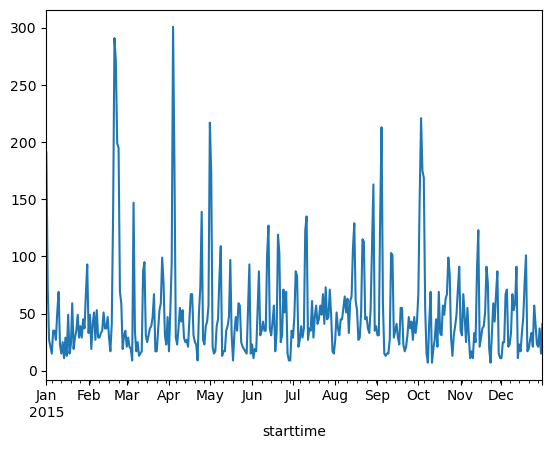

In [61]:
sales_ts.iloc[:,1].plot()
sales_ts.iloc[:,1]
plt.show()

In [62]:
sales_ts.loc['2015-01-01':'2015-11-30',352941].isna().sum()
sales_ts_data = sales_ts.loc['2015-01-01':'2015-11-30',352941]
sales_ts.loc['2015-12-01':'2015-12-31',352941].isna().sum()
sales_ts_con = sales_ts.loc['2015-12-01':'2015-12-31',352941]

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


用SimpleExpSmoothing

In [64]:
ses = SimpleExpSmoothing(sales_ts_data,initialization_method='estimated').fit()
ses.forecast(31)
ses_con = ses.forecast(31)

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ExponentialSmoothing

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2015-12-01    39.222328
2015-12-02    38.877693
2015-12-03    46.939687
2015-12-04    43.151312
2015-12-05    60.727659
2015-12-06    40.495876
2015-12-07    43.322789
2015-12-08    39.100979
2015-12-09    38.756344
2015-12-10    46.818339
2015-12-11    43.029964
2015-12-12    60.606310
2015-12-13    40.374528
2015-12-14    43.201441
2015-12-15    38.979631
2015-12-16    38.634996
2015-12-17    46.696990
2015-12-18    42.908615
2015-12-19    60.484962
2015-12-20    40.253179
2015-12-21    43.080093
2015-12-22    38.858282
2015-12-23    38.513647
2015-12-24    46.575642
2015-12-25    42.787267
2015-12-26    60.363614
2015-12-27    40.131831
2015-12-28    42.958744
2015-12-29    38.736934
2015-12-30    38.392299
2015-12-31    46.454294
Freq: D, dtype: float64


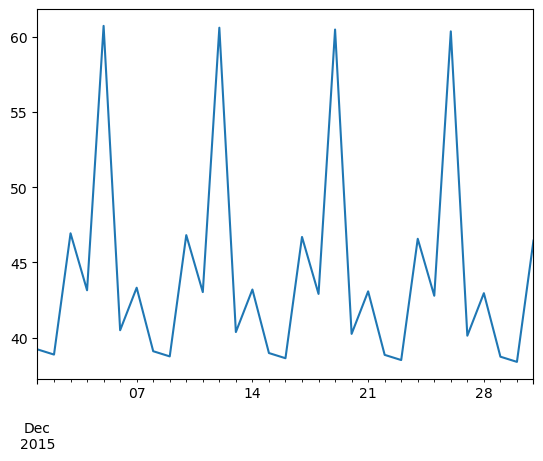

In [65]:
es = ExponentialSmoothing(sales_ts_data,trend='add',seasonal='add',seasonal_periods=7,initialization_method='estimated').fit()
print(es.forecast(31))
es_con = es.forecast(31)
es.forecast(31).plot()
plt.show()

ARIMA

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2015-12-01    60.453260
2015-12-02    42.073925
2015-12-03    60.870302
2015-12-04    56.525413
2015-12-05    80.235162
2015-12-06    54.136539
2015-12-07    55.563965
2015-12-08    67.225652
2015-12-09    49.752833
2015-12-10    63.673707
2015-12-11    62.508278
2015-12-12    74.898405
2015-12-13    63.315624
2015-12-14    66.485233
2015-12-15    78.067508
2015-12-16    60.249300
2015-12-17    76.027774
2015-12-18    73.650949
2015-12-19    90.353931
2015-12-20    73.240513
2015-12-21    75.746337
2015-12-22    87.358869
2015-12-23    69.672257
2015-12-24    84.742973
2015-12-25    82.827698
2015-12-26    97.887452
2015-12-27    82.881245
2015-12-28    85.639976
2015-12-29    97.240980
2015-12-30    79.504229
2015-12-31    94.844605
Freq: D, Name: predicted_mean, dtype: float64


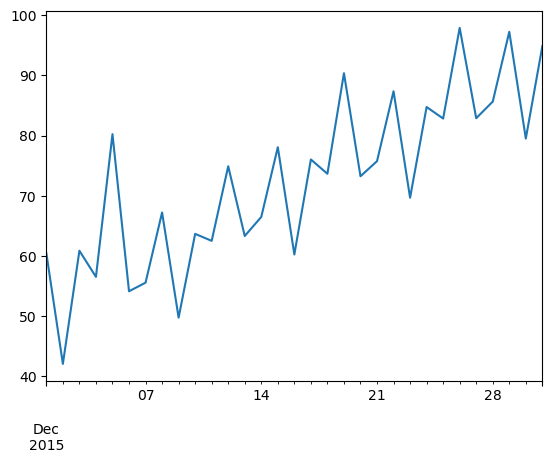

In [66]:
from statsmodels.tsa.arima.model import ARIMA
ar = ARIMA(sales_ts_data,order=(1,1,0),seasonal_order=(1,1,0,7)).fit()
print(ar.forecast(31))
ar_con = ar.forecast(31)
ar.forecast(31).plot()
plt.show()

ETSModel

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2015-12-01    37.934145
2015-12-02    39.085189
2015-12-03    46.817873
2015-12-04    54.136595
2015-12-05    69.659416
2015-12-06    36.497858
2015-12-07    38.667557
2015-12-08    36.928626
2015-12-09    38.079670
2015-12-10    45.812354
2015-12-11    53.131076
2015-12-12    68.653897
2015-12-13    35.492339
2015-12-14    37.662038
2015-12-15    35.923107
2015-12-16    37.074151
2015-12-17    44.806835
2015-12-18    52.125557
2015-12-19    67.648378
2015-12-20    34.486820
2015-12-21    36.656519
2015-12-22    34.917588
2015-12-23    36.068632
2015-12-24    43.801316
2015-12-25    51.120038
2015-12-26    66.642859
2015-12-27    33.481301
2015-12-28    35.650999
2015-12-29    33.912069
2015-12-30    35.063113
2015-12-31    42.795797
Freq: D, Name: simulation, dtype: float64


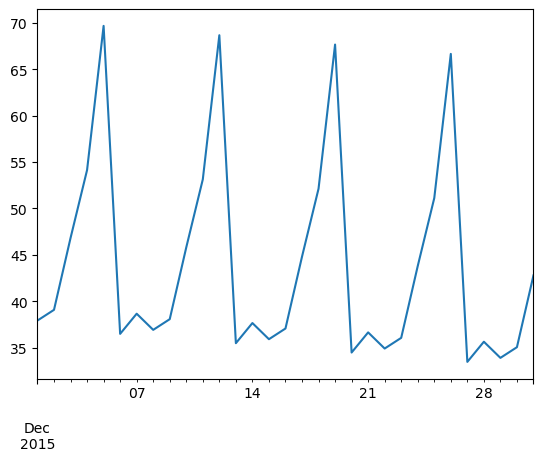

In [67]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
ets = ETSModel(sales_ts_data,seasonal='add',trend ='add',seasonal_periods=7,initialization_method='estimated').fit()
print(ets.forecast(31))
ets_con = ets.forecast(31)
ets.forecast(31).plot()
plt.show()

计算数据平均值，scikit-learn库来计算不同时间序列预测模型的性能指标

In [68]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
ses_mae = mean_absolute_error(sales_ts_con,ses_con)
ses_mse = mean_squared_error(sales_ts_con,ses_con)
ses_mape = mean_absolute_percentage_error(sales_ts_con,ses_con)

es_mae = mean_absolute_error(sales_ts_con,es_con)
es_mse = mean_squared_error(sales_ts_con,es_con)
es_mape = mean_absolute_percentage_error(sales_ts_con,es_con)

ar_mae=mean_absolute_error(sales_ts_con,ar_con)
ar_mse=mean_squared_error(sales_ts_con,ar_con)
ar_mape=mean_absolute_percentage_error(sales_ts_con,ar_con)

ets_mae = mean_absolute_error(sales_ts_con,ets_con)
ets_mse = mean_squared_error(sales_ts_con,ets_con)
ets_mape = mean_absolute_percentage_error(sales_ts_con,ets_con)

dt_mae = mean_absolute_error(y_val,tree_pred)
dt_mse = mean_squared_error(y_val,tree_pred)
dt_mape = mean_absolute_percentage_error(y_val,tree_pred)

rf_mae = mean_absolute_error(y_val,rf_pred)
rf_mse = mean_squared_error(y_val,rf_pred)
rf_mape = mean_absolute_percentage_error(y_val,rf_pred)
print("ses_mae:"+str(ses_mae))
print("ses_mse:"+str(ses_mse))
print("ses_mape:"+str(ses_mape))

print("es_mae:"+str(es_mae))
print("es_mse:"+str(es_mse))
print("es_mape:"+str(es_mape))

print("ar_mae:"+str(ar_mae))
print("ar_mse:"+str(ar_mse))
print("ar_mape:"+str(ar_mape))

print("ets_mae:"+str(ets_mae))
print("ets_mse:"+str(ets_mse))
print("ets_mape:"+str(ets_mape))

print('dt_mae:'+str(dt_mae))
print('dt_mse:'+str(dt_mse))
print('dt_mape:'+str(dt_mape))

print('rf_mae:'+str(rf_mae))
print('rf_mse:'+str(rf_mse))
print('rf_mape'+str(rf_mape))



ses_mae:11.658713926304468
ses_mse:203.67992377241194
ses_mape:0.3627634060572205
es_mae:12.46534209033431
es_mse:247.34285232063934
es_mape:0.39007207003864286
ar_mae:32.08087241779961
ar_mse:1315.9634940541323
ar_mape:1.0137728022815786
ets_mae:12.444144739882036
ets_mse:264.5408000956661
ets_mape:0.3741012029455259
dt_mae:7.671711957666049
dt_mse:194.80862763115408
dt_mape:0.8027864742062158
rf_mae:7.517914541876824
rf_mse:172.80036696864028
rf_mape0.807197218185856
